# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
!pip install pandas==1.5.3
!pip install tsfel
!pip install keras_tuner
!pip install -U kaleido

In [2]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '/content/drive/MyDrive/dataset/normal'#'../dataset/normal'0
ROOTDIR_DATASET_ANOMALY = '/content/drive/MyDrive/dataset/collisions'#'../dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [5]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
# freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [6]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 313.4157416820526 seconds ---


In [7]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


In [8]:
X_test

,machine_nameKuka Robot_apparent_power-_Average power,machine_nameKuka Robot_apparent_power-_Variance,machine_nameKuka Robot_current-_Min,machine_nameKuka Robot_phase_angle-_Average power,machine_nameKuka Robot_phase_angle-_Variance,machine_nameKuka Robot_power-_ECDF Percentile_0,machine_nameKuka Robot_power-_Min,machine_nameKuka Robot_power_factor-_Histogram_9,machine_nameKuka Robot_reactive_power-_Absolute energy,machine_nameKuka Robot_reactive_power-_ECDF Percentile_0,...,sensor_id5_AngX-_Median absolute deviation,sensor_id5_AngX-_Skewness,sensor_id5_AngY-_Median absolute deviation,sensor_id5_AngZ-_Median absolute deviation,sensor_id5_GyroY-_Mean absolute deviation,sensor_id5_GyroY-_Median,sensor_id5_GyroY-_Median absolute deviation,sensor_id5_GyroZ-_Histogram_7,sensor_id5_GyroZ-_Histogram_8,sensor_id5_GyroZ-_Median
0,-5.248946,-2.837749,0.178280,-4.835013,-2.682028,-4.818418,-4.676896,-5.045009,-0.132393,2.326834,...,-2.592859,-0.077106,-3.846887,-1.153095,-5.194760,-0.138292,-0.242340,-1.003753,-0.916365,-0.296547
1,-5.267211,-2.837186,0.621275,-4.768911,-2.678170,-4.813628,-4.684546,-5.045009,-0.221476,2.392709,...,-2.592859,3.510378,-3.846887,-1.153095,-5.194760,-0.138292,-0.242340,-1.003753,-0.916365,-0.296547
2,-3.400356,-0.158622,0.774434,-3.095669,4.461454,-4.793142,-4.656155,-2.816754,0.042834,2.195930,...,-2.589818,2.031357,-3.846887,-1.153095,-3.247640,-0.138292,-0.242340,-0.068263,2.234246,-0.296547
3,-4.089354,-1.229719,0.047146,-3.600176,2.068751,-4.819228,-4.676423,-3.559506,-0.086385,1.665751,...,-2.589818,2.307600,-3.846887,-1.153095,-1.850906,-0.138292,-0.242340,-1.003753,0.133839,-0.296547
4,-5.323114,-2.837860,0.671315,-4.656961,-2.680954,-4.829545,-4.692984,-5.045009,-0.421132,2.845343,...,-2.592859,5.093170,-3.846887,-1.153095,-5.194760,-0.138292,-0.242340,-1.003753,-0.916365,-0.296547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,-0.860780,-0.405256,-0.938652,-0.016770,0.177217,-0.061160,-0.266707,1.268382,1.363257,2.028320,...,1.660828,0.232278,-1.277529,-0.100114,-0.352543,-0.122391,-0.207245,0.867228,0.133839,-0.291220
302,-0.518975,-0.412879,0.596537,-0.399217,-0.495285,-0.058140,0.098193,2.382509,4.594739,1.102148,...,1.706436,-0.080201,-2.260842,0.145419,-1.199778,-0.137026,-0.239544,-0.068263,2.234246,-0.295517
303,-1.173762,0.929147,-0.951337,-1.265806,6.953499,-3.508636,-4.861357,0.790898,5.803125,-1.343088,...,1.610660,0.503717,0.324876,0.085563,-0.025717,-0.116375,-0.193968,-0.068263,-0.916365,-0.285036
304,-1.406423,-0.347934,0.300126,-1.514162,4.447207,-0.110018,-5.040850,1.056167,5.293446,-0.021047,...,-0.586116,0.332981,-1.641751,0.344533,-0.141087,-0.120702,-0.203518,-1.003753,0.133839,-0.295580



## Random Forest

In [9]:
num_estims = [10, 100, 1000]
crits = ['gini', 'entropy', 'log_loss']
max_dept = [None, 50, 100, 1000]
min_s_splits = [2, 3]
max_features = ['sqrt', 'log2', None]
fitted_clfs = []

classifier = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'entropy',
    max_depth = 100,
    min_samples_split = 2,
    max_features = 'sqrt'
    )
# Train the RandomForestClassifier on normal data
classifier.fit(X_train, y_train)
fitted_clfs.append(classifier)
print("Random Forest training completed.")


Random Forest training completed.


### Anomaly Detection

Anomaly prediction completed.


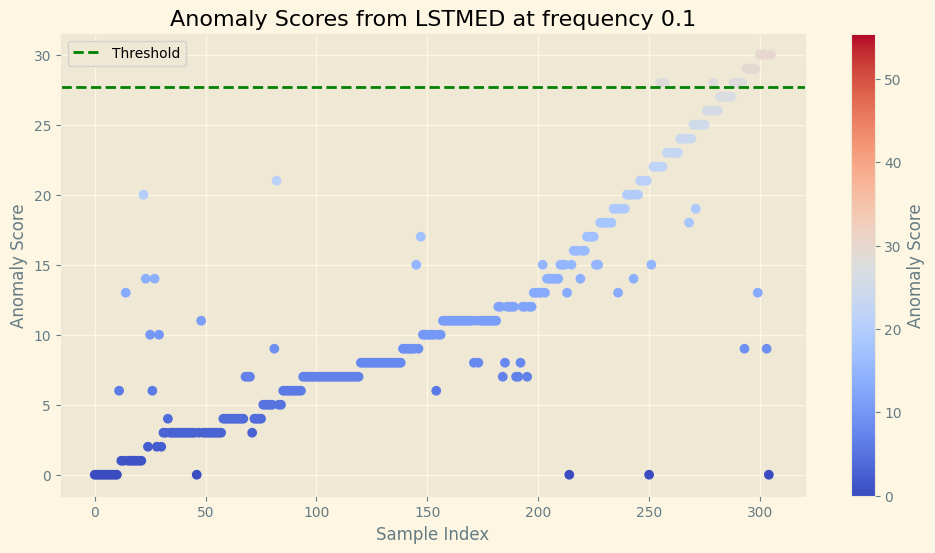

Number of anomalies detected: 17


In [10]:
# for classifier in fitted_clfs:
#   print(classifier)
#   print("-------------------------------------------- New classifier --------------------------------------------")
anomaly_scores, anomalies_detected, anomalies_pred = plot_anomalies(classifier, X_test, y_test, freq)

In [11]:
anomalies_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [12]:
# for classifier in fitted_clfs:
#   print("-------------------------------------------- New classifier --------------------------------------------")
anomaly_scores, y_test_binary = compute_metrics(classifier, X_test, anomalies_pred)

Anomaly scores statistics:
Mean: 11.50326797385621
Std: 8.09673877946118
Min: 0
Max: 30
ROC AUC Score: 1.0000
Detected anomaly class: 1.0
F1 Score: 1.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       289
           1       1.00      1.00      1.00        17

    accuracy                           1.00       306
   macro avg       1.00      1.00      1.00       306
weighted avg       1.00      1.00      1.00       306



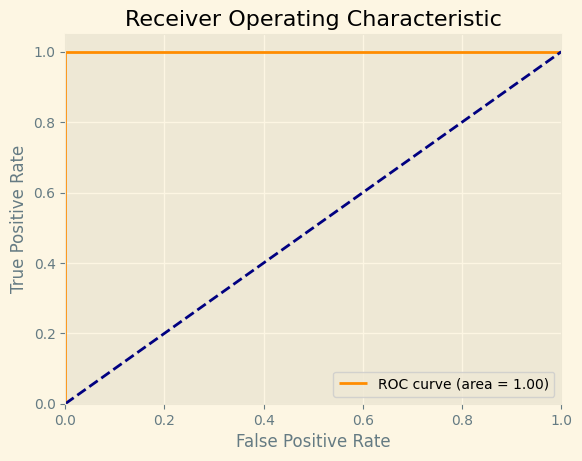

In [13]:
plot_roc_curve(y_test_binary, anomaly_scores)

## Map anomalies to original time series

THRESH: 27.69674553277857
0     -5.248946
1     -5.267211
2     -3.400356
3     -4.089354
4     -5.323114
         ...   
301   -0.860780
302   -0.518975
303   -1.173762
304   -1.406423
305   -1.455966
Name: machine_nameKuka Robot_apparent_power-_Average power, Length: 306, dtype: float64
		Questa feature non supera mai soglia
0     -2.837749
1     -2.837186
2     -0.158622
3     -1.229719
4     -2.837860
         ...   
301   -0.405256
302   -0.412879
303    0.929147
304   -0.347934
305    0.177675
Name: machine_nameKuka Robot_apparent_power-_Variance, Length: 306, dtype: float64
		Questa feature non supera mai soglia
0      0.178280
1      0.621275
2      0.774434
3      0.047146
4      0.671315
         ...   
301   -0.938652
302    0.596537
303   -0.951337
304    0.300126
305   -0.957586
Name: machine_nameKuka Robot_current-_Min, Length: 306, dtype: float64
		Questa feature non supera mai soglia
0     -4.835013
1     -4.768911
2     -3.095669
3     -3.600176
4     -4.656961
       

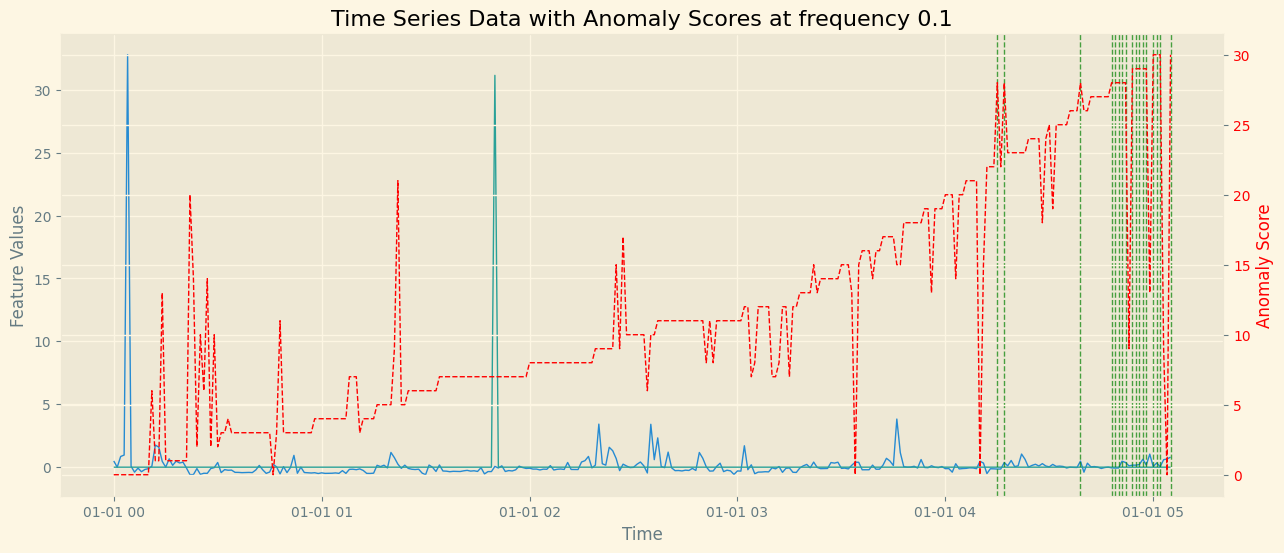

Top 17 Anomalies:
              timestamp  anomaly_score  \
300 2023-01-01 05:00:00             30   
301 2023-01-01 05:01:00             30   
302 2023-01-01 05:02:00             30   
305 2023-01-01 05:05:00             30   
294 2023-01-01 04:54:00             29   
295 2023-01-01 04:55:00             29   
296 2023-01-01 04:56:00             29   
297 2023-01-01 04:57:00             29   
298 2023-01-01 04:58:00             29   
255 2023-01-01 04:15:00             28   
257 2023-01-01 04:17:00             28   
279 2023-01-01 04:39:00             28   
288 2023-01-01 04:48:00             28   
289 2023-01-01 04:49:00             28   
290 2023-01-01 04:50:00             28   
291 2023-01-01 04:51:00             28   
292 2023-01-01 04:52:00             28   

     machine_nameKuka Robot_apparent_power-_Average power  \
300                                           0.189507      
301                                          -0.860780      
302                                       

In [14]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)